# [ATLAS-CONF-2013-102](https://cds.cern.ch/record/1601811/files/ATLAS-CONF-2013-102.pdf)

## ATLAS & CMS top mass combination at $\sqrt{s} = 7$ TeV

This notebook reproduces the results of the ATLAS and CMS top mass combination performed with 7 TeV measurements. The note referenced above includes many details of the combination and many cross-checks which we will attempt to reproduce.

Let's begin with our imports, we are going to make some plots so we'll include matplotlib.

In [1]:
%matplotlib inline

In [2]:
from blue import Blue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Step one is to read in the data, which we have stored in a csv file. Let's read it in with `pandas` and have a look at the dataframe it produces.

In [3]:
df = pd.read_csv('data/lhc_top_mass_7tev.csv', index_col='Exp')
df.T

Exp,ATLASljets,ATLASdilep,CMSljets,CMSdilep,CMSalljets,rho_exp,rho_lhc
Result,172.31,173.09,173.49,172.50,173.49,0.0,0.0
JSF,0.72,0.00,0.33,0.00,0.00,0.0,0.0
uJES,0.61,0.73,0.24,0.69,0.69,1.0,0.0
insituJES,0.29,0.31,0.02,0.35,0.35,1.0,0.0
intercalibJES,0.19,0.39,0.01,0.08,0.08,1.0,0.5
flavourJES,0.36,0.02,0.11,0.58,0.58,1.0,0.0
bJES,0.08,0.71,0.61,0.76,0.49,1.0,0.5
MC,0.33,0.48,0.02,0.04,0.19,1.0,1.0
Rad,0.45,0.37,0.30,0.58,0.33,1.0,1.0
CR,0.32,0.29,0.54,0.13,0.15,1.0,1.0


The data contains five measurements, two from ATLAS and three from CMS. Two of the rows in the dataframe show the assigned correlations both within a single experiment (rho_exp) and those between the two experiments (rho_lhc). We will seperate these from the other rows in the table and use them to create correlation matrices.

In [4]:
input_correlation = df.loc[['rho_exp', 'rho_lhc']].drop('Result', axis=1)
df = df.drop(['rho_exp', 'rho_lhc'])

df no only contains the results from the five measurements and the correlations are now stored in a seperate dataframe. We will define a couple of helper functions to construct our correlation matrices. The first simply takes in a values of rho_exp and rho_lhc and constructs a matrix based on those inputs. The second loops through our `input_correlation` dataframe and returns a dictionary mapping the names of the uncertainties to the correlation matrices.

In [5]:
def make_correlation_matrix(rho_exp, rho_lhc):
    n_atlas, n_cms = 2, 3
    rho_atlas = np.full((n_atlas, n_atlas), rho_exp)
    rho_cms = np.full((n_cms, n_cms), rho_exp)
    rho_inter = np.full((n_atlas, n_cms), rho_lhc)
    corr_mat = np.block([
        [rho_atlas, rho_inter],
        [rho_inter.T, rho_cms]
    ])
    np.fill_diagonal(corr_mat, 1)
    return corr_mat

def make_correlation_matrices(data):
    out = {}
    for i in data.columns:
        rho_exp = data.loc['rho_exp'][i]
        rho_lhc = data.loc['rho_lhc'][i]
        out[i] = make_correlation_matrix(rho_exp, rho_lhc)
    return out

In [6]:
correlation = make_correlation_matrices(input_correlation)

### LHC combination

Now that we have our correlations in the right format, we can create an instance of the `Blue` class and immediately look at the combined result.

In [7]:
blue = Blue(df, correlation)
blue.combined_result

173.28879459299242

which can be compared to the quoted result in the note of 173.29 GeV. We can get each of the combined uncertainties and look at them:

In [8]:
uncertainties = pd.Series(blue.combined_uncertainties)
uncertainties

JSF              0.257810
uJES             0.288117
insituJES        0.096643
intercalibJES    0.067218
flavourJES       0.165050
bJES             0.435214
MC               0.141823
Rad              0.320085
CR               0.431148
UE               0.171953
PDF              0.090729
Jet              0.199551
btagging         0.248844
Lepton           0.013480
MCBkg            0.079656
DataBkg          0.035857
Method           0.063507
MPI              0.053326
Stats            0.230016
dtype: float64

and then compute the combined systematic uncertainty by adding up all the uncertainties except the statistical uncertainty in quadrature.

In [9]:
total_syst = np.sqrt((uncertainties.drop('Stats') ** 2).sum())
total_syst

0.9179750264866068

So the combined result, including uncertainties, is:

In [10]:
print(f'm_top = {blue.combined_result:.2f}'
      f' +/- {uncertainties["Stats"]:.2f} (stat)' 
      f' +/- {total_syst:.2f} (syst)')

m_top = 173.29 +/- 0.23 (stat) +/- 0.92 (syst)


The $\chi^2$ and number-of-degrees-of-freedom can obtained (compare with the note values of 1.8 and 4):

In [11]:
blue.chi2_ndf

(1.7994655945280245, 4)

and we can then use `scipy` to covert those into a p-value (compare the note value of 77%)

In [12]:
from scipy.stats import chi2
chi2.sf(*blue.chi2_ndf)

0.7725801249272244

The BLUE weights can be obtained with:

In [13]:
blue.weights

array([ 0.22669616,  0.03663751,  0.6047318 , -0.08176875,  0.21370329])

but let's make a nice plot of them like in the note, we use `pandas` built in plotting here (with `matplotlib`) to make a simple bar chart (compare with Fig. 1(a))

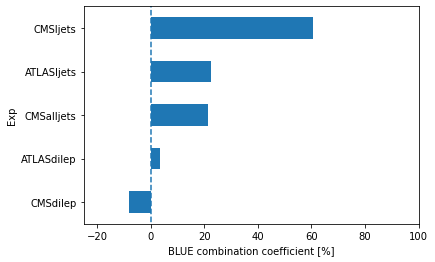

In [14]:
pd.Series(blue.weights * 100, index=blue.data.index).sort_values().plot.barh()
plt.vlines([0], -1, 5, linestyle='--')
ax = plt.gca()
ax.set(xlim=(-25, 100), xlabel='BLUE combination coefficient [%]');

Likewise we can look at the pulls of each measurement:

[(-1.0, 1.0), Text(0.5, 0, 'Pull')]

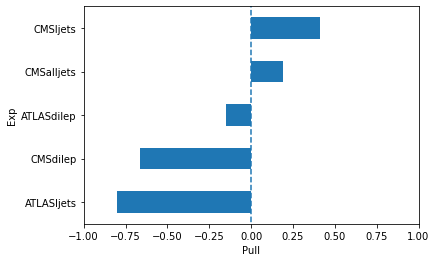

In [15]:
blue.pulls.sort_values().plot.barh()
plt.vlines([0], -1, 5, linestyle='--')
ax = plt.gca()
ax.set(xlim=(-1, 1), xlabel='Pull')

In both cases we have sorted the data before plotting so we plot in ascending order.

Table 2 of the note contains information about the various weights that can be inspected to try to assign an importance of each measurement to the combination. We look at the BLUE weights, the intrinsic information weights (IIW) and the marginal information weights (MIW):

In [16]:
blue_weights = pd.Series(blue.weights, index=blue.data.index, name='BLUE weights')
intrinsic_inf_weights = pd.Series(blue.intrinsic_information_weights, index=blue.data.index, name='IIW')
intrinsic_inf_weights['Correlation'] = 1 - intrinsic_inf_weights.sum()
marginal_inf_weights = pd.Series(blue.marginal_information_weights, index=blue.data.index, name='MIW')
np.round(100 * pd.DataFrame([blue_weights, intrinsic_inf_weights, marginal_inf_weights]).T, 1)

,BLUE weights,IIW,MIW
Exp,,,
ATLASljets,22.7,37.4,8.2
ATLASdilep,3.7,34.0,0.2
CMSljets,60.5,79.2,25.0
CMSdilep,-8.2,38.9,0.6
CMSalljets,21.4,45.0,4.3
Correlation,NaN,-134.4,NaN


We see slighly different values to those quoted in the note. Perhaps this is due to rounding somwhere (e.g. in our inputs)?

We can also look at the correlations between the input measurements:

In [17]:
pd.DataFrame(blue.total_correlations,
             index=blue.data.index,
             columns=blue.data.index).round(2)

Exp,ATLASljets,ATLASdilep,CMSljets,CMSdilep,CMSalljets
Exp,,,,,
ATLASljets,1.00,0.63,0.26,0.18,0.16
ATLASdilep,0.63,1.00,0.36,0.25,0.24
CMSljets,0.26,0.36,1.00,0.64,0.56
CMSdilep,0.18,0.25,0.64,1.00,0.75
CMSalljets,0.16,0.24,0.56,0.75,1.00


The next check performed in the note is a combination in which the top mass in the l+jets, dilepton and all-jets channels are treated as different observables. We can create a dictionary that maps our output observables to input measurements like so (note that the values of the dictionary should be lists even if there is only a single measurement):

In [18]:
channels = {
    'ljets': ['ATLASljets', 'CMSljets'],
    'dilep': ['ATLASdilep', 'CMSdilep'],
    'allhad': ['CMSalljets'],
}

We can then create a new instance of the `Blue` class with the same dataframe and correlations as previously, but now with the observables keyword argument set to our channels dictionary

In [19]:
channel_blue = Blue(df, correlation, observables=channels)
channel_blue.combined_result

{'ljets': 173.1755348763919,
 'dilep': 172.8465991359826,
 'allhad': 173.6360539416519}

We get one result per channel which can be compared with Table 3 of the note.

We can also look at how each of these observables are correlated with one another:

In [20]:
channel_blue.observable_correlations.round(2)

array([[1.  , 0.72, 0.56],
       [0.72, 1.  , 0.7 ],
       [0.56, 0.7 , 1.  ]])

We can perfom a similar test by looking at the individual experiments:

In [21]:
experiments = {
    'ATLAS': ['ATLASljets', 'ATLASdilep'],
    'CMS': ['CMSdilep', 'CMSljets', 'CMSalljets'],
}
experiment_blue = Blue(df, correlation, observables=experiments)
experiment_blue.combined_result

{'ATLAS': 172.6957966595784, 'CMS': 173.50077159132803}

In [22]:
experiment_blue.observable_correlations.round(2)

array([[1.  , 0.33],
       [0.33, 1.  ]])

A final combination that we can perform is using only measurements from one experiment at a time. This is different from the above combination when the results of each experiment are combined simultaneously and correlations between the two experiments are still present. 

Rather than having to redefine our correlation matrices, we can create new instances of the `Blue` class from our original instance like so:

In [23]:
blue[experiments['ATLAS']].combined_result

172.6491670717874

In [24]:
blue[experiments['CMS']].combined_result

173.58341686340304

### Effects of using alternative correlation models and uncertainty treatments

Now that we have perfomed a combination, we can test how the result changes if we change our assumptions on how our uncertainties are correlated. The first check performed in the note is to see how applying a multiplicative factor, $f$, to each correlation changes the result. This is done both at the same time and seperately for each of $\rho_{\mathrm{exp}}$ and $\rho_{\mathrm{lhc}}$.

The first thing we do is create a `numpy` array of evenly spaced points between 0 and 1. These are our test values for $f$:

In [25]:
x = np.linspace(0, 1, 21)

Next, we create many instance of the `Blue` class, varying the correlation assumptions:

In [26]:
vary_both = [Blue(df, make_correlation_matrices(input_correlation * f)) for f in x]
vary_fexp = [Blue(df, make_correlation_matrices((input_correlation.T * [f, 1]).T)) for f in x]
vary_flhc = [Blue(df, make_correlation_matrices((input_correlation.T * [1, f]).T)) for f in x]

Now that we have all our different assumptions in place we can plot the combined result and compare it to our "nominal" assumptions:

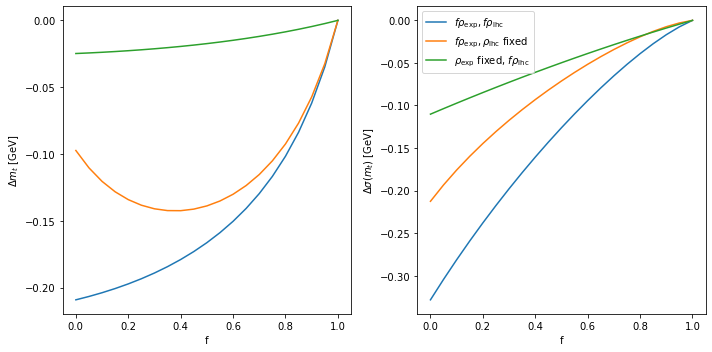

In [27]:
nominal_result = blue.combined_result
nominal_uncert = np.sqrt(blue.combined_covariance).squeeze()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

ax0.plot(x, [i.combined_result - nominal_result for i in vary_both], 
         label=r'$f \rho_{\mathrm{exp}}, f \rho_{\mathrm{lhc}}$')
ax0.plot(x, [i.combined_result - nominal_result for i in vary_fexp],
        label=r'$f \rho_{\mathrm{exp}}, \rho_{\mathrm{lhc}}$ fixed')
ax0.plot(x, [i.combined_result - nominal_result for i in vary_flhc],
        label=r'$\rho_{\mathrm{exp}} fixed, f \rho_{\mathrm{lhc}}$')

ax1.plot(x, [np.sqrt(i.combined_covariance).squeeze() - nominal_uncert for i in vary_both], 
         label=r'$f \rho_{\mathrm{exp}}, f \rho_{\mathrm{lhc}}$')
ax1.plot(x, [np.sqrt(i.combined_covariance).squeeze() - nominal_uncert for i in vary_fexp],
        label=r'$f \rho_{\mathrm{exp}}, \rho_{\mathrm{lhc}}$ fixed')
ax1.plot(x, [np.sqrt(i.combined_covariance).squeeze() - nominal_uncert for i in vary_flhc],
        label=r'$\rho_{\mathrm{exp}}$ fixed, $f \rho_{\mathrm{lhc}}$')
ax1.legend(loc='best')

ax0.set(ylabel='$\Delta m_t$ [GeV]', xlabel='f')
ax1.set(ylabel=r'$\Delta\sigma(m_t)$ [GeV]', xlabel='f')
plt.tight_layout();

which we can compare to Figures 2(a) and 2(b). We see they are nicely consistent!